In [2]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set the path to the folder containing audio files
audio_folder = "audio/audio"  # Replace with the path to your audio files folder

# Set the parameters for Mel spectrogram
n_fft = 512  # Number of points in each FFT
hop_length = n_fft  # Hop size
fft_len = n_fft//2 + 1  # Number of Mel bands
window = "hann"  # Window function
stft_taken = fft_len//4

# Initialize an empty matrix
stft_matrix = []
flux_arr = []
spectogram_matrix = []
mfcc_matrix = []

# Iterate through audio files in the folder
for filename in sorted(os.listdir(audio_folder)):
    if filename.endswith(".wav"):  # Adjust the file extension if needed
        audio_path = os.path.join(audio_folder, filename)

        # Load the audio file
        y, sr = librosa.load(audio_path)
        if sr != 22050:
            print(sr)

        stft = np.abs(librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, window=window))
        flux = librosa.onset.onset_strength(y=y, sr=sr, n_fft=n_fft, hop_length = hop_length)
        flux = flux
        mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr, n_fft=n_fft, hop_length=hop_length)
        
        mfcc_matrix.append(mfcc)
        stft_matrix.append(stft[:stft_taken,:])
        flux_arr.append(flux)

stft_matrix = np.hstack(stft_matrix)
flux_arr = np.hstack(flux_arr)
mfcc_matrix = np.hstack(mfcc_matrix)


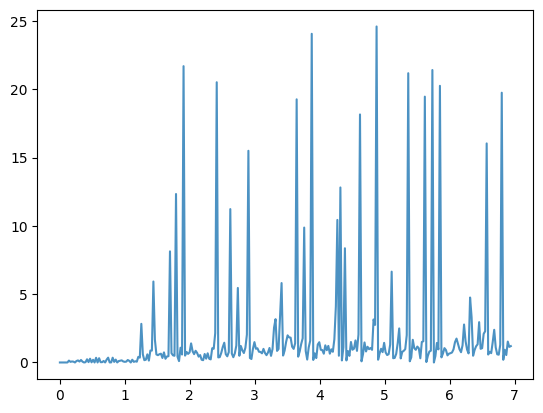

In [56]:
fig, ax = plt.subplots(nrows=1, sharex=True)
times = librosa.times_like(stft_matrix[:,:300])
ax.plot(times, flux_arr[:300], alpha=0.8, label='Mean (mel)')

In [3]:
flux_arr = flux_arr.T
stft_matrix = stft_matrix.T
mfcc_matrix = mfcc_matrix.T

In [4]:
print(flux_arr.shape)
print(stft_matrix.shape)

(43005,)
(43005, 64)


In [59]:
features = np.column_stack((stft_matrix, flux_arr*4))
features.shape 

(202194, 65)

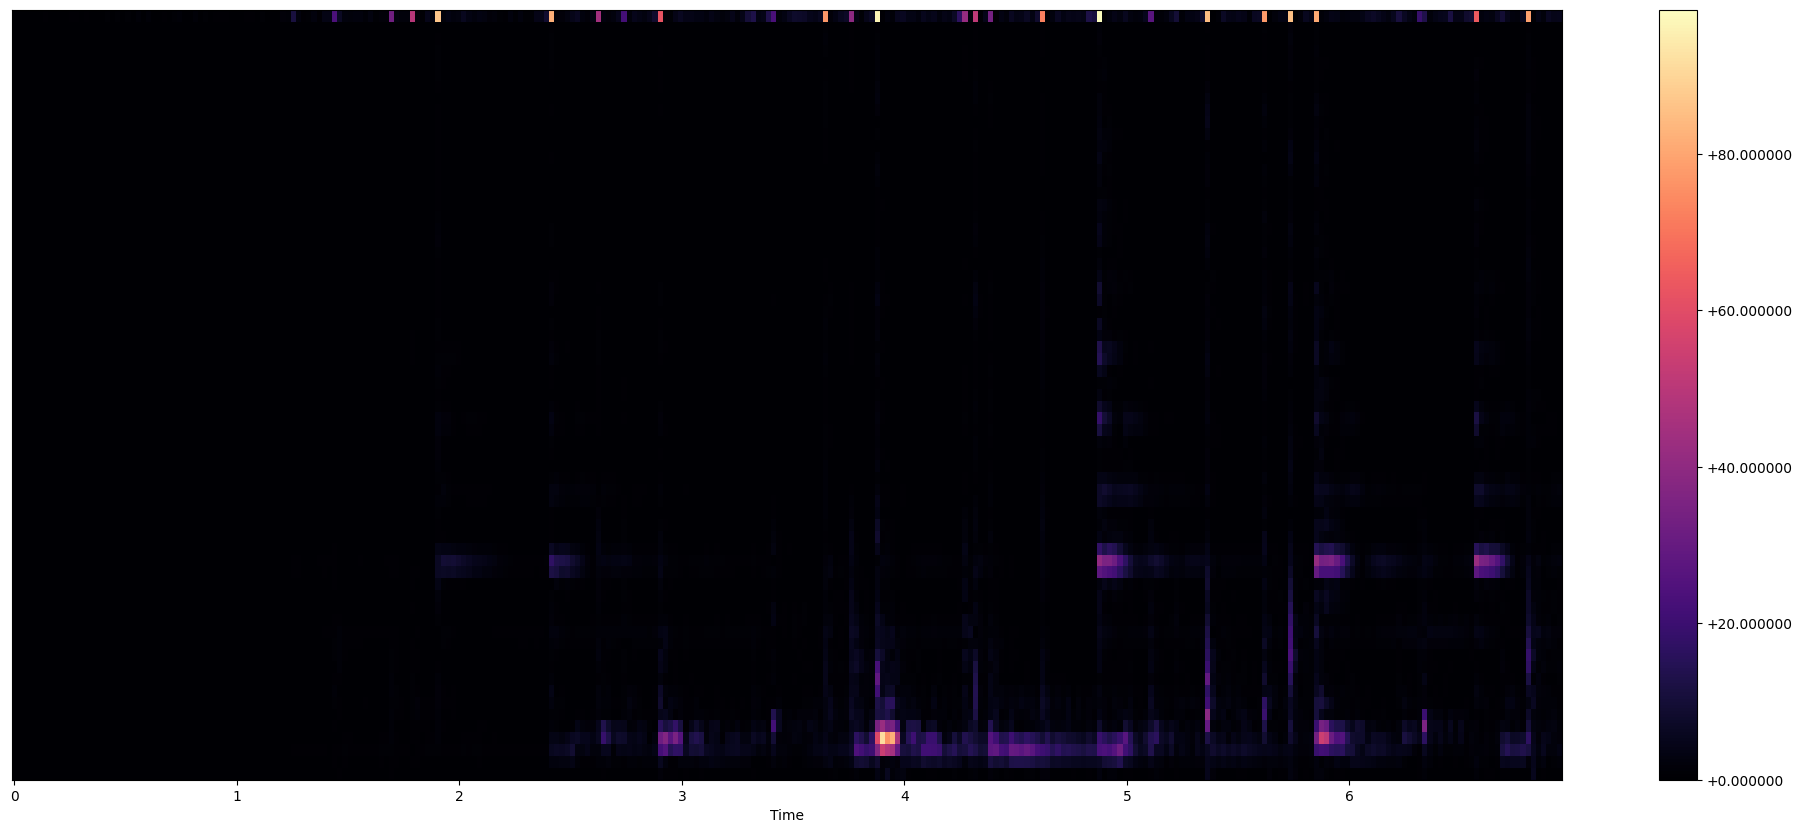

In [60]:
#Plot
plt.figure(figsize=(25,10))
librosa.display.specshow(features.T[:,:300], x_axis="time",sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [61]:
# Define the time_step of the audio file
time_step = hop_length/22050

audio_folder = "4way-tabla-ismir21-dataset/train/audios" 
onset_folder = "4way-tabla-ismir21-dataset/train/onsets"

# Initialize an empty matrix to store the spectrograms
label_array = []

for filename in sorted(os.listdir(audio_folder)):

    file_name, extension = os.path.splitext(filename)
    onsetfile = f"{file_name}.{'onsets'}"

    # Provide the path to your audio file
    audio_file_path = os.path.join(audio_folder, filename)
    
    # Load the audio file
    y, sr = librosa.load(audio_file_path)

    # Calculate the duration of the audio in seconds
    audio_duration = librosa.get_duration(y=y, sr=sr)


    # Calculate the number of time steps and initialize the array with zeros
    num_time_steps = int(audio_duration / time_step)
    num_time_steps += 1
    stroke_array = np.zeros(num_time_steps)
    
    # Read the .ONSETS file to get the times of the strokes
    for i in ["b", "d", "rb", "rt"]:
        file_path = os.path.join(onset_folder, i, onsetfile)
        with open(file_path, 'r') as file:
            stroke_times = [float(line.strip()) for line in file]

        # Set the values to 1 where there is a stroke within the time period
        for stroke_time in stroke_times:
            time_step_index = int(stroke_time / time_step)
            if time_step_index < num_time_steps:
                stroke_array[time_step_index] = 1
        
    
    label_array.append(stroke_array)

label_array = np.hstack(label_array)

label_array = label_array.T   


In [62]:
print(features.shape)
print(label_array.shape)

(202194, 65)
(202194,)


In [63]:
#Ckeck the no. of -ve and +ve values to check class imbalance
zero = 0
one = 0

for i in label_array:
    if i==0:
        zero+=1
    elif i==1:
        one+=1

print(zero, ", ", one)

#Find class imbalance
print(one*100/(zero+one), "% Positive Values")

176540 ,  25654
12.687814673036787 % Positive Values


In [64]:
pos_features = features[label_array == 1][:]
pos_labels = label_array[label_array == 1]
print(pos_features.shape)
print(pos_labels.shape)
print(pos_labels)

(25654, 65)
(25654,)
[1. 1. 1. ... 1. 1. 1.]


In [65]:
t = zero//one - 2 
r = zero % one
pos_features_stack = pos_features

for i in range(t):
    pos_features_stack = np.vstack((pos_features_stack, pos_features))

pos_labels_stack = np.tile(pos_labels, t+1)
pos_features_stack = np.vstack((pos_features_stack, pos_features[:r,:]))
pos_labels_stack = np.concatenate([pos_labels_stack, pos_labels[:r]])

new_features = np.vstack((features, pos_features_stack))
new_labels = np.concatenate([label_array, pos_labels_stack])
print(features.shape)
print(label_array.shape)

(202194, 65)
(202194,)


In [66]:
print(new_features.shape)
print(new_labels.shape)

(353080, 65)
(353080,)


In [67]:
#Ckeck the no. of -ve and +ve values to check class imbalance
zero = 0
one = 0

for i in new_labels:
    if i==0:
        zero+=1
    elif i==1:
        one+=1

print(zero, ", ", one)

#Find class imbalance
print(one*100/(zero+one), "% Positive Values")

176540 ,  176540
50.0 % Positive Values


In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_features, new_labels, test_size=0.2, random_state=42)
# X_train = X_train.reshape(X_train.shape[0], 1, 1)

In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_addons.metrics import F1Score
# from sklearn.utils.class_weight import compute_class_weight

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(65,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Create an instance of the F1Score metric.
f1_score = F1Score(num_classes=2, average='micro')

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy', f1_score])

# class_weights = dict(zip(np.unique(label_array), compute_class_weight('balanced', classes=np.unique(label_array), y=label_array)))
# class_weights = {int(label): weight_for_class for label, weight_for_class in class_weights.items()}
#class_weights = {0: 1, 1: 9}





In [ ]:
filepath="./ckpt" + str(i) + "/weights-improvement-{epoch:02d}-{accuracy:.2f}-{f1_score:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='f1_score', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X_train, y_train, epochs=700, callbacks=callbacks_list)

In [ ]:
model.save_weights('./ckpt1/700.hdf5')

In [183]:
model.evaluate(X_test,  y_test, verbose=2)

2207/2207 - 6s - loss: 0.3955 - accuracy: 0.8151 - f1_score: 0.6976 - 6s/epoch - 3ms/step


[0.3955278992652893, 0.815126895904541, 0.6976120471954346]

In [ ]:
new_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(65,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation='relu'),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu'),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),    
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu'),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

new_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy', f1_score])

In [ ]:
j=0

In [ ]:
filepath="./BNckpt" + str(j) + "/wght-imprv-{epoch:02d}-{accuracy:.2f}-{f1_score:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='f1_score', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

new_model.fit(X_train, y_train, epochs=300, callbacks=callbacks_list)
j += 1

Epoch 1/300
8818/8827 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.7754 - f1_score: 0.6764
Epoch 1: f1_score improved from -inf to 0.67637, saving model to ./BNckpt2\wght-imprv-01-0.78-0.68.hdf5
8827/8827 [==============================] - 46s 5ms/step - loss: 0.4653 - accuracy: 0.7754 - f1_score: 0.6764
Epoch 2/300
8826/8827 [============================>.] - ETA: 0s - loss: 0.4641 - accuracy: 0.7743 - f1_score: 0.6755
Epoch 2: f1_score did not improve from 0.67637
8827/8827 [==============================] - 45s 5ms/step - loss: 0.4641 - accuracy: 0.7743 - f1_score: 0.6755
Epoch 3/300
8819/8827 [============================>.] - ETA: 0s - loss: 0.4661 - accuracy: 0.7729 - f1_score: 0.6760
Epoch 3: f1_score did not improve from 0.67637
8827/8827 [==============================] - 45s 5ms/step - loss: 0.4661 - accuracy: 0.7729 - f1_score: 0.6761
Epoch 4/300
8822/8827 [============================>.] - ETA: 0s - loss: 0.4652 - accuracy: 0.7738 - f1_score: 0.67

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_addons.metrics import F1Score

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [49]:
for batch_size in [5,25,125,625,3125,15625,78125,353080]:

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(100, activation='relu', input_shape=(65,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='relu'),    
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Create an instance of the F1Score metric.
    f1_score = F1Score(num_classes=2, average='micro')

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy', f1_score])
    model.load_weights("./batch_size-" + str(batch_size) + "/100.hdf5")

    filepath="./batch_size-" + str(batch_size) + "/weight--improvement-{epoch}-{accuracy:.2f}-{f1_score:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    model.fit(X_train, y_train, epochs=500, batch_size=batch_size, callbacks=callbacks_list)
    model.save_weights("./batch_size-" + str(batch_size) + "/600.hdf5")


Epoch 1/80
562/565 [============================>.] - ETA: 0s - loss: 0.4659 - accuracy: 0.7771 - f1_score: 0.6757
Epoch 1: accuracy improved from -inf to 0.77709, saving model to ./batch_size-625\weight-improvement-1-0.78-0.68.hdf5
565/565 [==============================] - 5s 7ms/step - loss: 0.4659 - accuracy: 0.7771 - f1_score: 0.6756
Epoch 2/80
563/565 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.7784 - f1_score: 0.6763
Epoch 2: accuracy improved from 0.77709 to 0.77828, saving model to ./batch_size-625\weight-improvement-2-0.78-0.68.hdf5
565/565 [==============================] - 4s 7ms/step - loss: 0.4635 - accuracy: 0.7783 - f1_score: 0.6763
Epoch 3/80
562/565 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.7788 - f1_score: 0.6769
Epoch 3: accuracy improved from 0.77828 to 0.77882, saving model to ./batch_size-625\weight-improvement-3-0.78-0.68.hdf5
565/565 [==============================] - 4s 7ms/step - loss: 0.4621 - accurac

In [ ]:
model.load_weights("batch_size-625/20.hdf5")

In [ ]:
batch_size=625
filepath="./625-batch_size" + str(batch_size) + "/weight-improvement2-{epoch}-{accuracy:.2f}-{f1_score:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X_train, y_train, epochs=5000, batch_size=batch_size, callbacks=callbacks_list)
model.save_weights("./batch_size-" + str(batch_size) + "/6000.hdf5")

Epoch 1/5000
445/452 [============================>.] - ETA: 0s - loss: 0.3901 - accuracy: 0.8243 - f1_score: 0.6874
Epoch 1: accuracy improved from -inf to 0.82429, saving model to ./625-batch_size625\weight-improvement2-1-0.82-0.69.hdf5
452/452 [==============================] - 3s 8ms/step - loss: 0.3902 - accuracy: 0.8243 - f1_score: 0.6874
Epoch 2/5000
449/452 [============================>.] - ETA: 0s - loss: 0.3906 - accuracy: 0.8248 - f1_score: 0.6869
Epoch 2: accuracy improved from 0.82429 to 0.82476, saving model to ./625-batch_size625\weight-improvement2-2-0.82-0.69.hdf5
452/452 [==============================] - 3s 7ms/step - loss: 0.3906 - accuracy: 0.8248 - f1_score: 0.6869
Epoch 3/5000
449/452 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.8242 - f1_score: 0.6861
Epoch 3: accuracy did not improve from 0.82476
452/452 [==============================] - 3s 8ms/step - loss: 0.3908 - accuracy: 0.8242 - f1_score: 0.6861
Epoch 4/5000
446/452 [=========

In [ ]:
model.evaluate(X_test,  y_test, verbose=2)

2207/2207 - 7s - loss: 0.3384 - accuracy: 0.8543 - f1_score: 0.6858 - 7s/epoch - 3ms/step


[0.3384332060813904, 0.8543389439582825, 0.6858328580856323]

In [21]:
import csv

In [7]:
model.load_weights("625-batch_size625/weight-improvement2-4778-0.83-0.69.hdf5")

In [22]:

audio_folder = "audio/audio"  # Replace with the path to your audio files folder
threshold = 0.5

n_fft = 512  # Number of points in each FFT
hop_length = n_fft  # Hop size
fft_len = n_fft//2 + 1  # Number of Mel bands
window = "hann"  # Window function
stft_taken = fft_len//4

# Iterate through audio files in the folder
for filename in sorted(os.listdir(audio_folder)):
    audio_path = os.path.join(audio_folder, filename)

    # Load the audio file
    y, sr = librosa.load(audio_path)
    if sr != 22050:
        print(sr)

    stft = np.abs(librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, window=window))
    flux = librosa.onset.onset_strength(y=y, sr=sr, n_fft=n_fft, hop_length = hop_length)
    flux = flux
    stft_new = stft[:stft_taken,:]
    #mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr, n_fft=n_fft, hop_length=hop_length)

    stft_new = stft_new.T
    print(stft.shape)
    print(flux.shape)
    features_test = np.column_stack((stft_new, flux*4))
    print(features_test.shape)
    prediction_test = model.predict(features_test)
    file = filename.split(".")[0]
    csv_file = "audio/onsets/" + file + ".csv"
    # Supress and amplify predictions to 0 and 1
    prediction_test[prediction_test >= threshold] = 1
    prediction_test[prediction_test < threshold] = 0
    prediction_test.astype(int)

    #Generate segments of speech from the predictions for each small segment
    previous_frame = 0
    stepLength = 512/22050

    data = [["Stroke", "Index"]]

    for i in range(len(prediction_test)):

        current_time = i*stepLength
        current_frame = prediction_test[i]
        #If previous frame has no stroke
        #and current frame has stroke
        if previous_frame == 0 and current_frame != 0:
            data.append([current_time, 1])

        previous_frame = current_frame


    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the data to the CSV file row by row
        for row in data:
            writer.writerow(row)
            
        
        

(257, 429)
(429,)
(429, 65)
14/14 [==============================] - 0s 3ms/step
(257, 430)
(430,)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(257, 429)
(429,)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(257, 430)
(430,)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(257, 431)
(431,)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(257, 431)
(431,)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(257, 430)
(430,)
(430, 65)
14/14 [==============================] - 0s 3ms/step
(257, 430)
(430,)
(430, 65)
14/14 [==============================] - 0s 3ms/step
(257, 431)
(431,)
(431, 65)
14/14 [==============================] - 0s 3ms/step
(257, 431)
(431,)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(257, 431)
(431,)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(257, 431)
(431,)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(257, 431)
(431,)
(431, 65)


In [ ]:



prediction_test = model.predict(test_features)





In [8]:
num_clusters = 4

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

In [23]:

audio_folder = "audio/audio"  # Replace with the path to your audio files folder
threshold = 0.5

n_fft = 512  # Number of points in each FFT
hop_length = n_fft  # Hop size
fft_len = n_fft//2 + 1  # Number of Mel bands
window = "hann"  # Window function
stft_taken = fft_len//4

# Iterate through audio files in the folder
for filename in sorted(os.listdir(audio_folder)):
    audio_path = os.path.join(audio_folder, filename)

    # Load the audio file
    y, sr = librosa.load(audio_path)
    if sr != 22050:
        print(sr)

    stft = np.abs(librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, window=window))
    flux = librosa.onset.onset_strength(y=y, sr=sr, n_fft=n_fft, hop_length = hop_length)
    mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr, n_fft=n_fft, hop_length=hop_length)
    stft = stft[:stft_taken,:]
    stft = stft.T
    mfcc = mfcc.T

    features_test = np.column_stack((stft, flux*4))

    prediction_test = model.predict(features_test)
    file = filename.split(".")[0]
    csv_file = "audio/clustered_onsets/" + file + ".csv"
    # Supress and amplify predictions to 0 and 1
    prediction_test[prediction_test >= threshold] = 1
    prediction_test[prediction_test < threshold] = 0
    prediction_test.astype(int)


    indices = np.array([i for i in range(prediction_test.shape[0])])
    indices = indices.reshape(-1, 1)
    print(indices.shape)
    print(prediction_test.shape)
    print(features_test.shape)
    
    pos_labels = prediction_test[prediction_test!=0]
    pos_index = indices[prediction_test != 0]
    pos_features = features_test[prediction_test[:, 0] != 0, :]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(pos_features)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    y_pred_kmeans = kmeans.fit_predict(features_scaled)
    #Generate segments of speech from the predictions for each small segment
    stepLength = 512/22050


    data = [["Stroke", "Index"]]

    for i in range(len(pos_labels)):

        current_time = pos_index[i]*stepLength
        current_frame = y_pred_kmeans[i]
        #If previous frame has no stroke
        #and current frame has stroke
        data.append([current_time, current_frame])\


    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the data to the CSV file row by row
        for row in data:
            writer.writerow(row)
            
        
        

 1/14 [=>............................] - ETA: 0s

14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 3ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 3ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)
 1/14 [=>............................] - ETA: 0s

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 3ms/step
(428, 1)
(428, 1)
(428, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 3ms/step
(430, 1)

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



(430, 1)
(430, 65)
 1/14 [=>............................] - ETA: 0s

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 3ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 3ms/step


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 1ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 3ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 3ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 3ms/step
(428, 1)
(428, 1)
(428, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 1ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)
14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)
14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(428, 1)
(428, 1)
(428, 65)
14/14 [==============================] - 0s 2ms/step
(431, 1)
(431, 1)
(431, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)
14/14 [==============================] - 0s 2ms/step
(429, 1)
(429, 1)
(429, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14/14 [==============================] - 0s 2ms/step
(430, 1)
(430, 1)
(430, 65)


c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:



print(pos_features.shape)
print(pos_labels.shape)

In [ ]:
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
y_pred_kmeans = kmeans.fit_predict(features_scaled)
# ari = adjusted_rand_score(pos_labels, y_pred_kmeans)
# print(f"Adjusted Rand Index (ARI): {ari}")

c:\Users\chinm\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): 0.007933165406509093


In [ ]:


#Generate segments of speech from the predictions for each small segment
previous_frame = 0
start_time = 0
stepLength = n_fft/22050

data = [["Stroke", "Index"]]
idx = 0

for i in range(len(y_pred_kmeans)):

    current_time = pos_index[i]*stepLength
    current_frame = y_pred_kmeans[i]
    #If previous frame has no stroke
    #and current frame has stroke
    if previous_frame == 0 and current_frame != 0:
        data.append([start_time, current_frame])
        idx += 1

    previous_frame = current_frame


# Open the CSV file in write mode
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the data to the CSV file row by row
    for row in data:
        writer.writerow(row)